# TDA examples

### Simple examples of persistent homology using ripser and persim.

In [1]:
!pip install scikit-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ripser: filename=ripser-0.6.4-cp310-cp310-linux_x86_64.whl size=88592 sha256=ad0ece71bf68fb59ab5412c09b8b5f30c39e3d047b59a9f0b1d1eb146cd7a244
  Stored in directory: /root/.cache/pip/wheels/c5/f5/66/f41f708b049057431155934f74e20ca6001a085fcd2e615150
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=d5052c881c42588fa5429ea7a747be482f7850e44a2b67f4e0dd9fc6032336a9
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built ripser hopcroftkarp


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import product
from ripser import ripser
from persim import plot_diagrams, PersistenceImager

### Example data

Helper functions to generate pointclouds of typical shapes.

In [3]:
def rotate(mat, x_angle: float = 0.0, y_angle: float = 0.0, z_angle: float = 0.0):
    x_rotate = np.array([[1, 0, 0], [0, np.cos(x_angle), np.cos(x_angle + np.pi/2)], [0, np.sin(x_angle), np.sin(x_angle + np.pi/2)]])
    y_rotate = np.array([[np.cos(y_angle), 0, np.cos(y_angle + np.pi/2)], [0, 1, 0], [np.sin(y_angle), 0, np.sin(y_angle + np.pi/2)]])
    z_rotate = np.array([[np.cos(z_angle), np.cos(z_angle + np.pi/2), 0], [np.sin(z_angle), np.sin(z_angle + np.pi/2), 0], [0, 0, 1]])
    return np.linalg.multi_dot([z_rotate, y_rotate, x_rotate, mat.T]).T

def scale(mat, x_scale: float = 1.0, y_scale: float = 1.0, z_scale: float = 1.0):
    scale_mat = np.array([[x_scale, 0, 0], [0, y_scale, 0], [0, 0, z_scale]])
    return np.matmul(scale_mat, mat.T).T

def shift(mat, shift: (float, float, float) = (0.0, 0.0, 0.0)):
    return mat + shift

def normalize(mat):
    scaling = np.max(np.absolute(mat))
    return shift(scale(mat, x_scale=0.5/scaling, y_scale=0.5/scaling, z_scale=0.5/scaling), shift=(0.5, 0.5, 0.5))

In [4]:
def get_circle(r: float = 1.0, center: (float, float, float) = (0.0, 0.0, 0.0),
               noise_angle: float = 0.0, noise_radius: float = 0.0, num: int = 1000):
    angles = np.linspace(0, 2*np.pi, num=num)
    if noise_angle != 0:
        angles += np.random.uniform(low=-noise_angle, high=noise_angle, size=num)
    if noise_radius != 0:
        radiuses = np.random.uniform(low=r-noise_radius, high=r+noise_radius, size=num)
    else:
        radiuses = np.full(fill_value=r, shape=num)
    return np.array([center[0]+radiuses*np.sin(angles), center[1]+radiuses*np.cos(angles), center[2]+np.zeros(num)]).T

def get_torus(r1: float = 5.0, r2: float = 1.0, center: (float, float, float) = (0.0, 0.0, 0.0),
              noise: float = 0.0, num_circle: int = 50, num_angles: int = 200, num: int = 0):
    if num != 0:
        num_angles = num//50
        num_circle = 50
    base_circle = get_circle(center=(r1, 0.0, 0.0), r=r2, num=num_circle)
    torus = np.concatenate([rotate(base_circle, y_angle=2*np.pi*i/num_angles) for i in range(num_angles)])
    if noise == 0:
        return torus
    add_noise = np.random.uniform(low=-noise, high=noise, size=(len(torus), 3))
    return torus + add_noise

def get_sphere(r: float = 1.0, center: (float, float, float) = (0.0, 0.0, 0.0),
               noise_angle: float = 0.0, noise_radius: float = 0.0, num_angles: int = 100):
    angles_1 = np.linspace(0, 2*np.pi, num=num_angles)
    angles_2 = np.linspace(0, 2*np.pi, num=num_angles)
    if noise_angle != 0:
        angles_1 += np.random.uniform(low=-noise_angle, high=noise_angle, size=num_angles)
        angles_2 += np.random.uniform(low=-noise_angle, high=noise_angle, size=num_angles)
    if noise_radius != 0:
        radiuses = np.random.uniform(low=r-noise_radius, high=r+noise_radius, size=(num_angles, num_angles))
    else:
        radiuses = np.full(fill_value=r, shape=(num_angles, num_angles))
    arr = [[center[0]+radiuses[i][j]*np.sin(angles_1[i])*np.cos(angles_2[j]) for i, j in product(range(num_angles), range(num_angles))]]
    arr.append([center[1]+radiuses[i][j]*np.sin(angles_1[i])*np.sin(angles_2[j]) for i, j in product(range(num_angles), range(num_angles))])
    arr.append([center[2]+radiuses[i][j]*np.cos(angles_1[i]) for i, j in product(range(num_angles), range(num_angles))])
    return np.array(arr).T

def get_cluster(num: int = 1, center: (float, float, float) = (0.0, 0.0, 0.0), noise: float = 0.0):
    return np.random.normal(loc=0.0, scale=noise, size=(num, 3)) + center

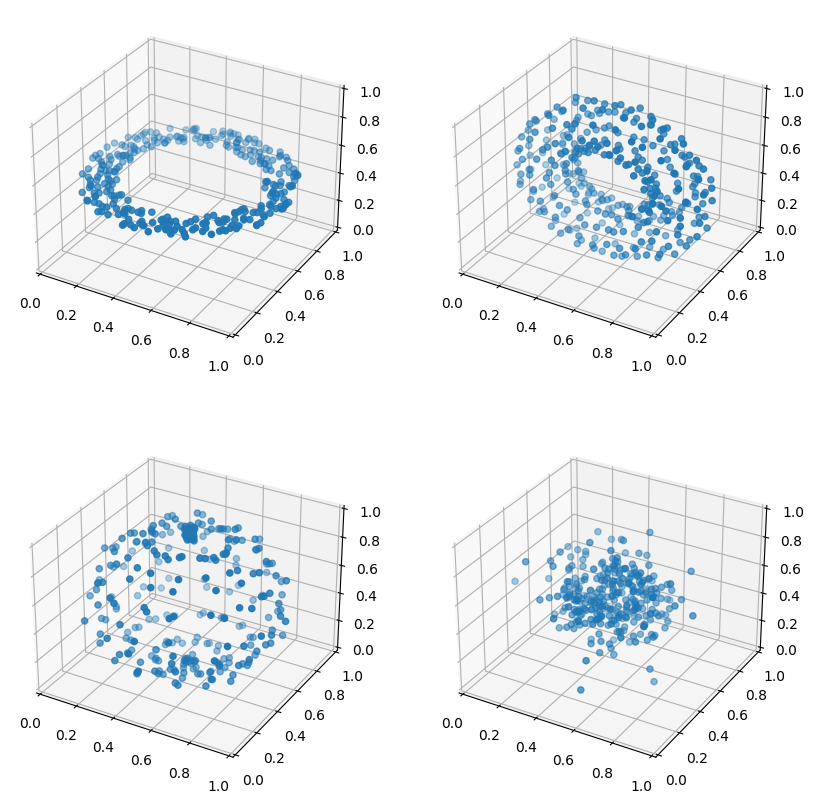

In [5]:
circle = get_circle(noise_angle=0.1, noise_radius=0.2, num=300)
circle = normalize(circle)

torus = get_torus(r1=1.0, r2=0.4, noise=0.05, num_circle=11, num_angles=31)
torus = normalize(torus)

sphere = get_sphere(r=1.0, noise_angle=0.1, noise_radius=0.1, num_angles=17)
sphere = normalize(sphere)

cluster = get_cluster(num=300, noise=0.2)
cluster = normalize(cluster)

pc_list = [circle, torus, sphere, cluster]

fig = plt.figure(figsize=(10, 10))
for i, pc in enumerate(pc_list):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.scatter(pc[:,0], pc[:,1], pc[:,2])

### Persistence diagrams: ripser

In [6]:
start_time = time.time()
dgm_list = [ripser(pc, maxdim=2)['dgms'] for pc in pc_list]
print(f"Time taken to compute {len(pc_list)} persistence diagrams: {time.time()-start_time:.0f} seconds.")

Time taken to compute 4 persistence diagrams: 41 seconds.


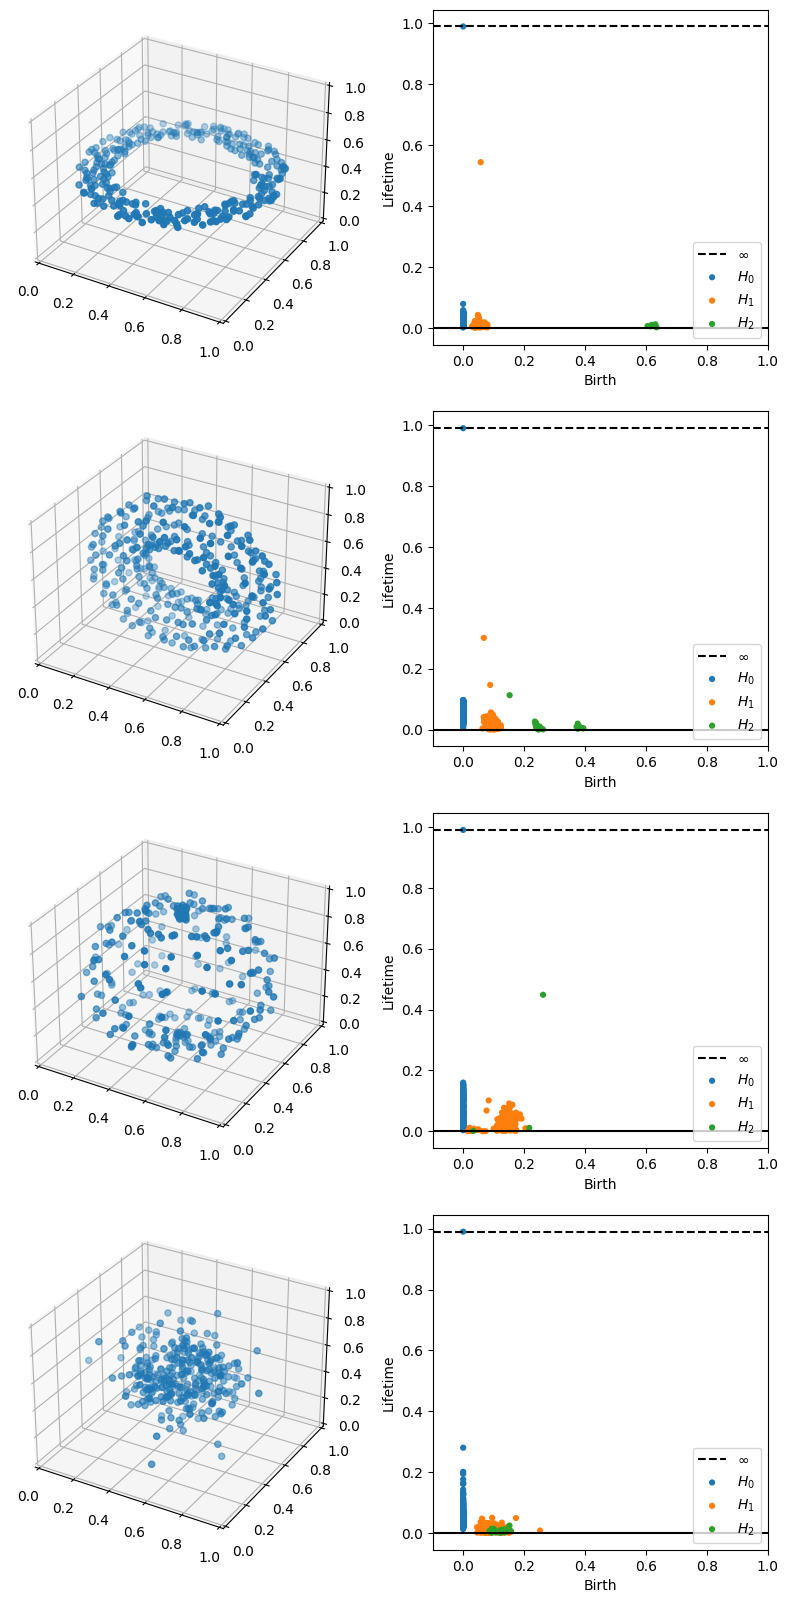

In [7]:
fig = plt.figure(figsize=(10, 20))
for i, (pc, dgm) in enumerate(zip(pc_list, dgm_list)):
    ax = fig.add_subplot(4, 2, 2*i+1, projection='3d')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.scatter(pc[:,0], pc[:,1], pc[:,2])
    
    ax = fig.add_subplot(4, 2, 2*i+2)
    plot_diagrams(dgm, xy_range=[-0.1, 1., -0.1, 1.], show=False, lifetime=True, ax=ax)
plt.show();

### Persistence images: persim

In [8]:
pimgr = PersistenceImager(pixel_size=.05,
                          weight='linear_ramp',
                          weight_params={'low':.0, 'high':1., 'start':0.05, 'end':1.},
                          kernel_params={'sigma': .005})
# fit the imager to all persistence diagrams
# we have 4 pointclouds, each of which has multiple diagrams: one for each dimension 0, 1, 2
# so we need to concatenate all of these, hence the next ugly line
all_dgms = np.concatenate((np.concatenate(dgm_list[0]), np.concatenate(dgm_list[1]), np.concatenate(dgm_list[2]), np.concatenate(dgm_list[3])))
# we also cannot have infinities in the diagrams, so we map them to finite values
max_value = 1.
all_dgms[all_dgms == float('inf')] = max_value
pimgr.fit(all_dgms)

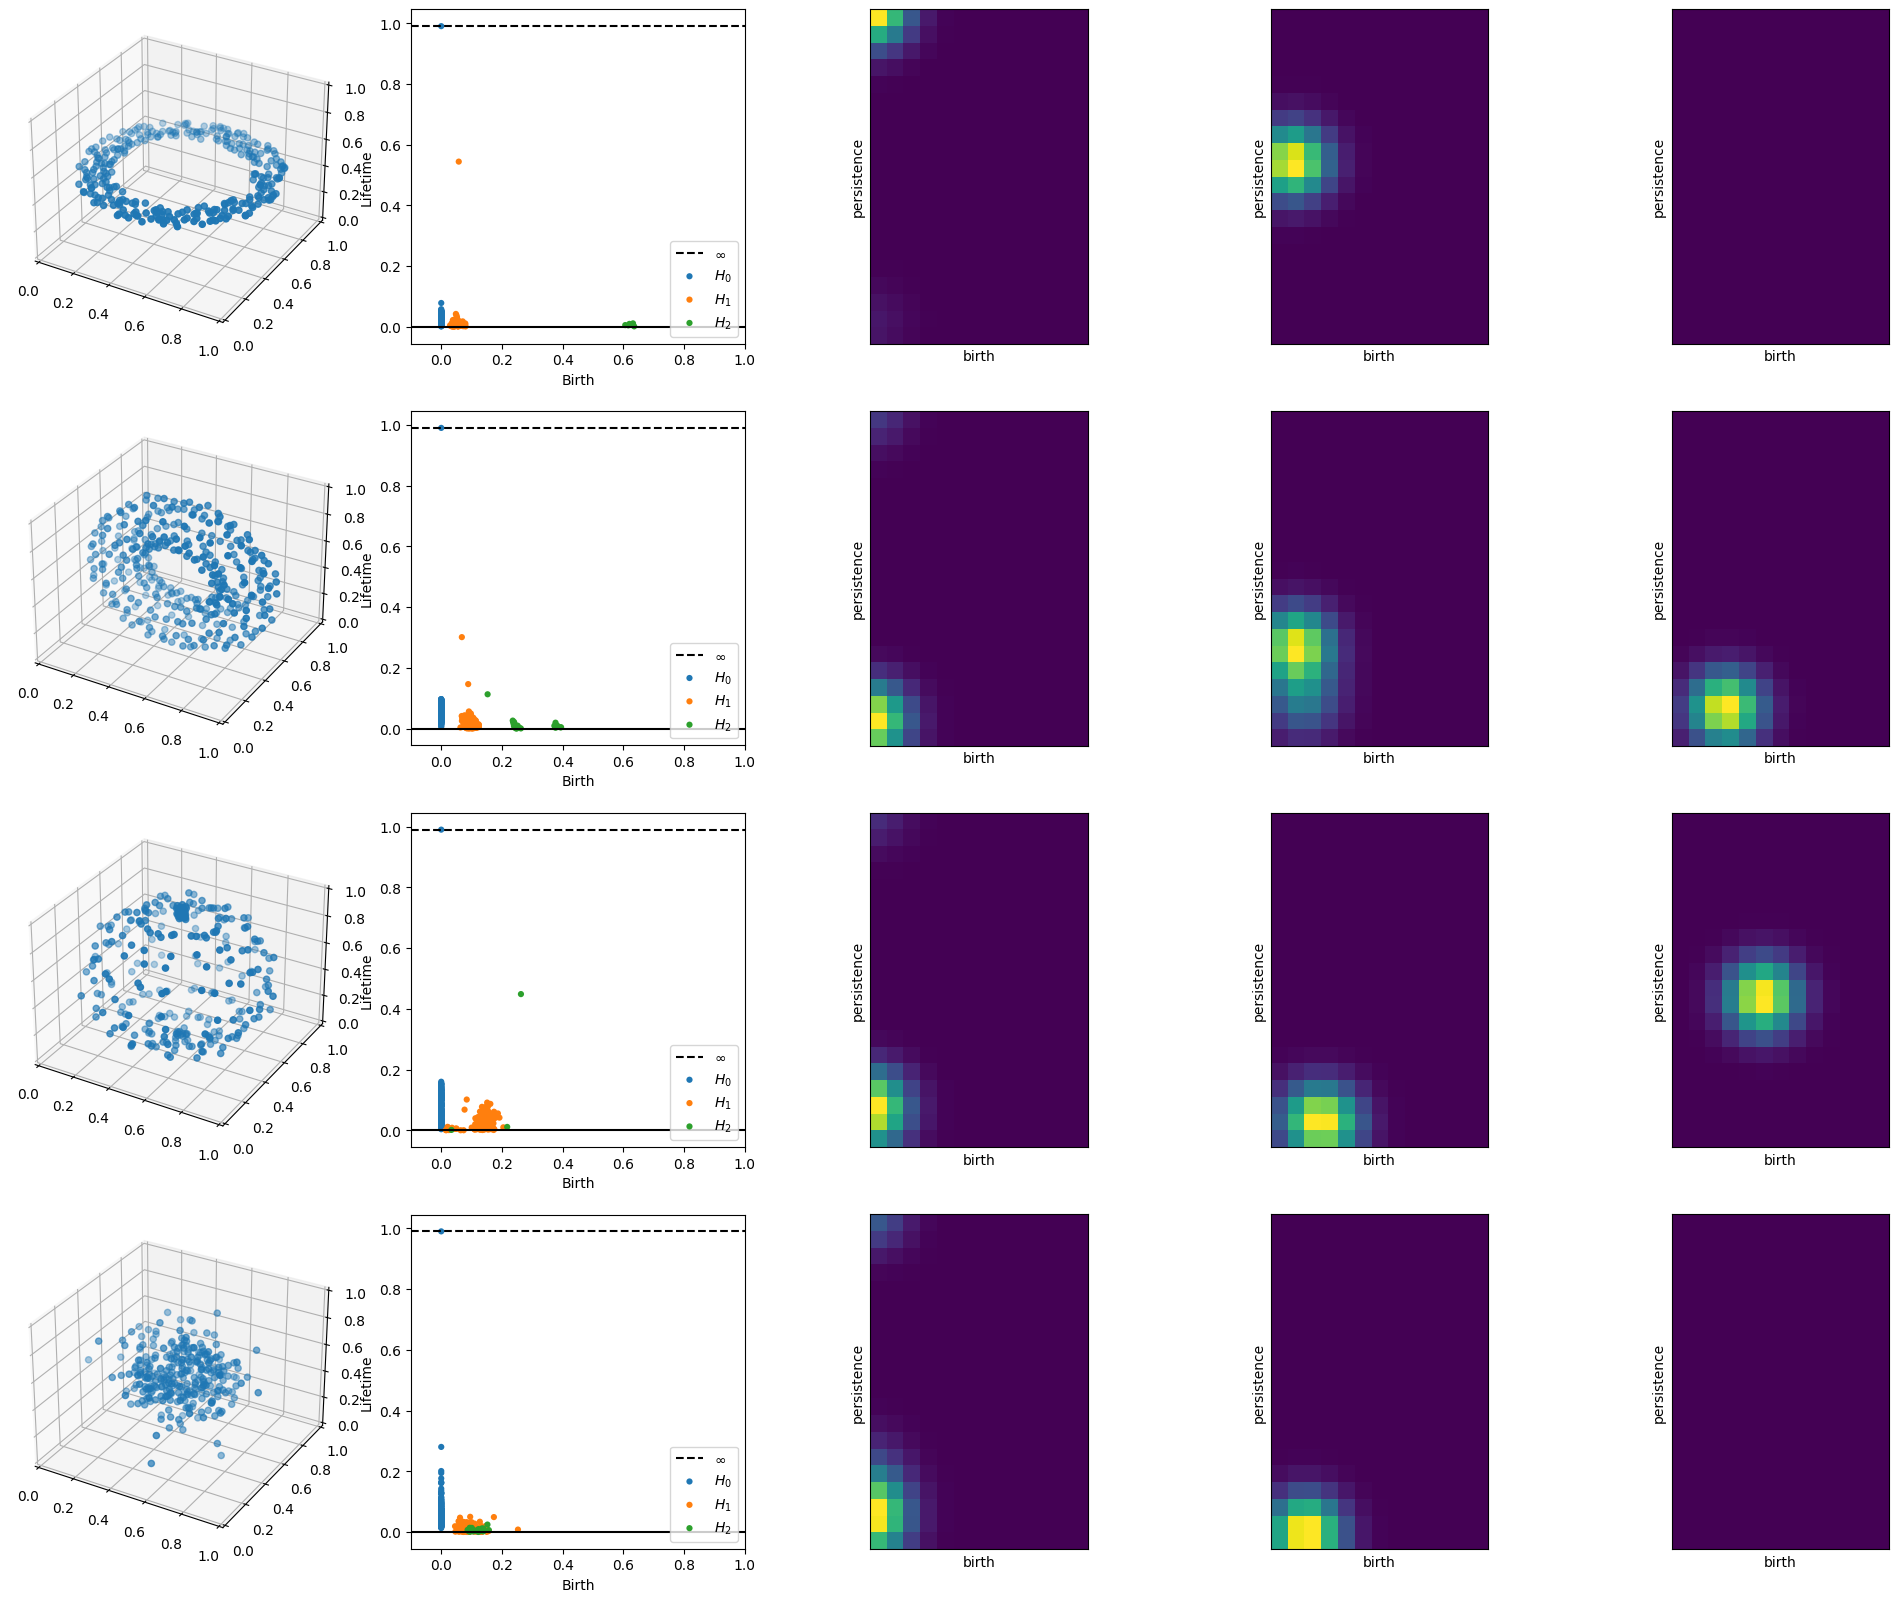

In [9]:
fig = plt.figure(figsize=(25, 20))
for i, (pc, dgm) in enumerate(zip(pc_list, dgm_list)):
    ax = fig.add_subplot(4, 5, 5*i+1, projection='3d')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.scatter(pc[:,0], pc[:,1], pc[:,2])
    
    ax = fig.add_subplot(4, 5, 5*i+2)
    plot_diagrams(dgm, xy_range=[-0.1, 1., -0.1, 1.], lifetime=True, ax=ax)
    
    ax = fig.add_subplot(4, 5, 5*i+3)
    h0_dgm = dgm_list[i][0]
    h0_dgm[h0_dgm == float('inf')] = max_value
    pimgr.plot_image(pimgr.transform(h0_dgm), ax=ax)
    
    ax = fig.add_subplot(4, 5, 5*i+4)
    pimgr.plot_image(pimgr.transform(dgm_list[i][1]), ax=ax)
    
    ax = fig.add_subplot(4, 5, 5*i+5)
    pimgr.plot_image(pimgr.transform(dgm_list[i][2]), ax=ax)